<a href="https://colab.research.google.com/github/BADS7604Group03/assignment3/blob/main/code/StockMarketPredictions_lightGBM_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


1.   https://github.com/borisbanushev/stockpredictionai
2.   https://www.datacamp.com/community/tutorials/lstm-python-stock-market
3.   https://docs.google.com/spreadsheets/d/15g1n16B21J5oIEeV6TwhlSKvNdG7IiqSq-mOoMT6p4M/edit#gid=504220406



# Set Environment

In [1]:
# List all NVIDIA GPUs as avaiable in this computer (or colub's session)
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-29c1d0fb-d6a2-dc0d-197b-ea9c2b1bd39b)


In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sys,os,time,datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [3]:
%matplotlib inline
print(f"Python {sys.version}")
print(f"NumPy {np.__version__}")
print(f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}")
gpus = tf.config.list_physical_devices('GPU')
print(f"Tensorflow detected : {len(gpus)} GPU(s)")
for i,gpu in enumerate(gpus):
  print(f" GPU No. {i} : Name = {gpu.name} , Type = {gpu.device_type}")


Python 3.7.13 (default, Mar 16 2022, 17:37:17) 
[GCC 7.5.0]
NumPy 1.21.5
tf.keras.backend.image_data_format() = channels_last
Tensorflow detected : 1 GPU(s)
 GPU No. 0 : Name = /physical_device:GPU:0 , Type = GPU


# Import data

In [4]:
file = "1AA_1WKPuI4wXQGKTxoMzf3tPrT47jq1P"
dwn_url=f"https://drive.google.com/uc?export=download&id={file}"
dfstok = pd.read_excel(dwn_url ,sheet_name='Daily')
dfstok = dfstok.sort_values(by='Date').reset_index(drop=True)
print(f"Shape of dfstock : {dfstok.shape}")
display(dfstok.head(2))

Shape of dfstock : (2469, 6)


,Date,Close,Open,High,Low,Volume
0,2012-02-09,5.60,5.64,5.64,5.60,4118750
1,2012-02-10,5.64,5.56,5.64,5.52,6783500


In [5]:
dfstok['return_close'] = dfstok.Close.diff(-1)/dfstok.Close
dfstok.head()

,Date,Close,Open,High,Low,Volume,return_close
0,2012-02-09,5.60,5.64,5.64,5.60,4118750,-0.007143
1,2012-02-10,5.64,5.56,5.64,5.52,6783500,0.014184
2,2012-02-13,5.56,5.64,5.64,5.56,1923000,0.014388
3,2012-02-14,5.48,5.60,5.60,5.44,3553750,-0.007299
4,2012-02-15,5.52,5.48,5.56,5.48,2479125,0.000000


# Explore data

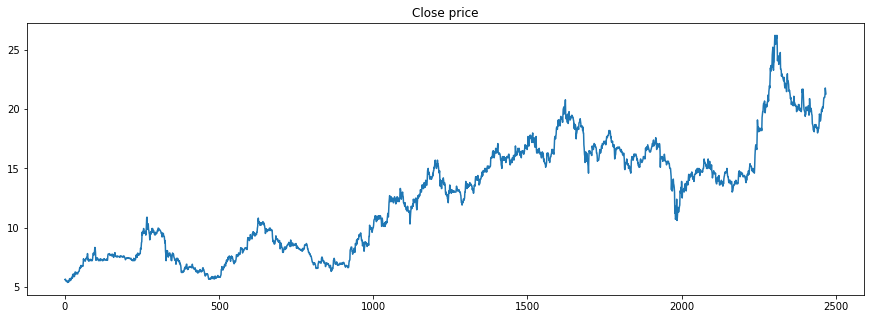

In [6]:
plt.figure(figsize = (15,5))
plt.plot(range(dfstok.shape[0]),dfstok['Close'])
plt.title('Close price')
plt.show()

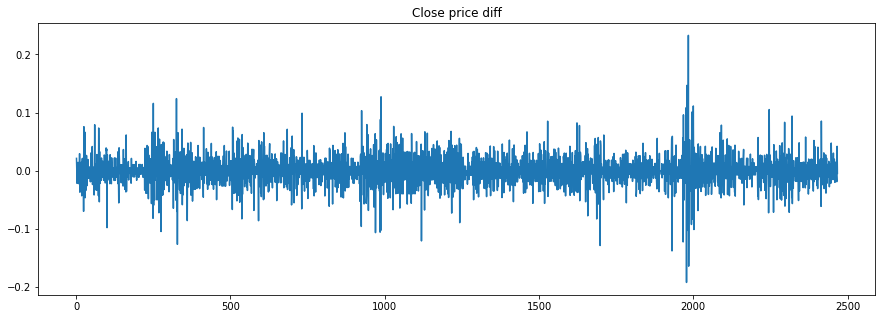

In [7]:
plt.figure(figsize = (15,5))
plt.plot(dfstok['return_close'].diff())
plt.title('Close price diff')
plt.show()

# Preprocess

## Create Sequence feature

In [8]:
def window_return(val, window):
  lst_x = []
  lst_y = []
  lst_x_return = []
  lst_y_return = []
  for i in range(0,len(val) - window -1,1):
    first_price = val[i]
    lst_x.append(val[i:i+window])
    lst_y.append(val[i+window])
    lst_x_return.append((val[i+1:i+window]-first_price)/first_price)
    lst_y_return.append((val[i+window]-first_price)/first_price)
  array_x_return = np.array(lst_x_return).reshape(-1,window-1)
  array_y_return = np.array(lst_y_return).reshape(-1,1)
  array_x = np.array(lst_x).reshape(-1,window)
  array_y = np.array(lst_y).reshape(-1,1)
  return array_x,array_x_return,array_y,array_y_return

In [9]:
x_close,x_return,y_close,y_return = window_return(dfstok.Close.values, 20)
print(f"x_close.shape : {x_close.shape}")
print(f"x_return.shape : {x_return.shape}")
print(f"y_close.shape : {y_close.shape}")
print(f"y_return.shape : {y_return.shape}")

x_close.shape : (2448, 20)
x_return.shape : (2448, 19)
y_close.shape : (2448, 1)
y_return.shape : (2448, 1)


## Split Train/Test Data set

In [10]:
def split(x_array, y_array, ratio_train=0.8, ratio_test=0.1):
  n_data = x_array.shape[0]
  n_train = int(n_data * ratio_train)    
  n_test = int(n_data *ratio_test)       
  n_val = n_data -n_train -n_test

  x_train, y_train = x_array[:n_train], y_array[:n_train] 
  x_val, y_val      = x_array[n_train:n_train+n_val], y_array[n_train:n_train+n_val]
  x_test, y_test   = x_array[n_train+n_val:], y_array[n_train+n_val:]
  return [x_train, x_val, x_test], [y_train, y_val, y_test]

In [11]:
# Split data tuples x-(train, val, test), y-(train, val, test)
lst_x_close ,lst_y_close = split(x_close, y_close, 0.8, 0.1)
lst_x_return ,lst_y_return = split(x_return, y_return, 0.8, 0.1)

In [12]:
print(f"Shape Price:{lst_x_close[0].shape} ,Val:{lst_x_close[1].shape}, Test:{lst_x_close[2].shape}")
print(f"Shape Return:{lst_x_return[0].shape} ,Val:{lst_x_return[1].shape}, Test:{lst_x_return[2].shape}")

Shape Price:(1958, 20) ,Val:(246, 20), Test:(244, 20)
Shape Return:(1958, 19) ,Val:(246, 19), Test:(244, 19)


In [13]:
print(f"Shape Price:{lst_y_close[0].shape} ,Val:{lst_y_close[1].shape}, Test:{lst_y_close[2].shape}")
print(f"Shape Return:{lst_y_return[0].shape} ,Val:{lst_y_return[1].shape}, Test:{lst_y_return[2].shape}")

Shape Price:(1958, 1) ,Val:(246, 1), Test:(244, 1)
Shape Return:(1958, 1) ,Val:(246, 1), Test:(244, 1)


## Normalize Data form train data set

In [14]:
#Fit Normalize tools
norm_tool = MinMaxScaler().fit(lst_x_return[0].reshape(-1,1))

In [15]:
def norm_val(norm_fn, lst_x, lst_y):
  return_x = [i for i in lst_x ]
  return_y = [i for i in lst_y ]
  for i in range(len(lst_x)):
    return_x[i] = norm_fn.transform(lst_x[i].reshape(-1,1)).reshape(lst_x[i].shape)
    return_y[i] = norm_fn.transform(lst_y[i].reshape(-1,1)).reshape(lst_y[i].shape)
  return return_x, return_y

In [16]:
lst_x_norm   ,lst_y_norm= norm_val(norm_tool, lst_x_return, lst_y_return)
print(f"Shape x:{lst_x_norm[0].shape} ,Val:{lst_x_norm[1].shape}, Test:{lst_x_norm[2].shape}")
print(f"Shape y:{lst_y_norm[0].shape} ,Val:{lst_y_norm[1].shape}, Test:{lst_y_norm[2].shape}")

Shape x:(1958, 19) ,Val:(246, 19), Test:(244, 19)
Shape y:(1958, 1) ,Val:(246, 1), Test:(244, 1)


## Create data train - validate - test ( Size , Time  , Feature)

In [17]:
#Create x array
x_train_norm = lst_x_norm[0]
x_val_norm   = lst_x_norm[1]
x_test_norm  = lst_x_norm[2]

In [18]:
#Create y array
y_train_norm = lst_y_norm[0]
y_val_norm   = lst_y_norm[1]
y_test_norm  = lst_y_norm[2]
y_test = lst_y_close[2]

In [19]:
print(f"\n x_train_norm.shape {x_train_norm.shape}{y_train_norm.shape} \n{x_train_norm[0]} -->y= {y_train_norm[0]}")
print(f"\n x_val_norm.shape {x_val_norm.shape}{y_val_norm.shape} \n{x_val_norm[0]} -->y={y_val_norm[0]}")
print(f"\n x_test_norm.shape {x_test_norm.shape}{y_test_norm.shape}\n{x_test_norm[0]} ")


 x_train_norm.shape (1958, 19)(1958, 1) 
[0.45923102 0.43481383 0.41039664 0.42260524 0.42260524 0.42260524
 0.39818805 0.37377085 0.38597945 0.38597945 0.41039664 0.38597945
 0.42260524 0.44702243 0.47143962 0.47143962 0.45923102 0.42260524
 0.45923102] -->y= [0.48364822]

 x_val_norm.shape (246, 19)(246, 1) 
[0.43599531 0.43599531 0.40291395 0.39188683 0.39188683 0.39188683
 0.34777836 0.314697   0.1933987  0.25956141 0.18237158 0.18237158
 0.22648005 0.25956141 0.29264277 0.24853429 0.23750717 0.21545294
 0.17134446] -->y=[-0.02714368]

 x_test_norm.shape (244, 19)(244, 1)
[0.43515296 0.42328349 0.41141402 0.38767509 0.37580562 0.43515296
 0.39954456 0.44702243 0.4588919  0.4588919  0.44702243 0.48263083
 0.4945003  0.4588919  0.4588919  0.51823924 0.54197817 0.56571711
 0.54197817] 


## Convert to float32

In [20]:
x_train_norm = x_train_norm.astype(np.float32)
y_train_norm = y_train_norm.astype(np.float32)
x_val_norm = x_val_norm.astype(np.float32)
y_val_norm = y_val_norm.astype(np.float32)
x_test_norm = x_test_norm.astype(np.float32)
y_test_norm = y_test_norm.astype(np.float32)

# LightGBM Regression

In [32]:
import lightgbm as lgb

In [210]:
#Prepare Model
dtrain = lgb.Dataset(x_train_norm, label=y_train_norm.ravel() )
dvalidate = lgb.Dataset(x_val_norm, label=y_val_norm.ravel() )

In [248]:
from traitlets.traitlets import Tuple
params = {
          'boosting_type': 'gbdt',
          'objective': 'regression',
          'metric':'l2',
          'num_leaves':10,
          'max_depth':5,
          'drop_rate ':0.3,
          'reg_sqrt':True,
          'boost_from_average':True,
          'learning_rate': 0.0001,
          'verbose': 0,
         }

In [249]:
#Run Model
start_tm = time.time()
evals_results = {}
model_lgbm = lgb.train(params, 
                  train_set =dtrain, 
                  valid_sets=dvalidate,
                  evals_result=evals_results, 
                  num_boost_round=1000, #iterations
                  early_stopping_rounds=100,
                  verbose_eval=50, 
                  feval=None)
print(f">>>>> Training Time >>>> {time.time() - start_tm} seconds")


Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 0.0218328
[100]	valid_0's l2: 0.0216337
[150]	valid_0's l2: 0.0214366
[200]	valid_0's l2: 0.0212416
[250]	valid_0's l2: 0.0210487
[300]	valid_0's l2: 0.020858
[350]	valid_0's l2: 0.0206692
[400]	valid_0's l2: 0.0204824
[450]	valid_0's l2: 0.0202975
[500]	valid_0's l2: 0.0201146
[550]	valid_0's l2: 0.0199333
[600]	valid_0's l2: 0.019754
[650]	valid_0's l2: 0.0195765
[700]	valid_0's l2: 0.0193996
[750]	valid_0's l2: 0.0192241
[800]	valid_0's l2: 0.0190501
[850]	valid_0's l2: 0.0188781
[900]	valid_0's l2: 0.0187082
[950]	valid_0's l2: 0.01854
[1000]	valid_0's l2: 0.018374
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.018374
>>>>> Training Time >>>> 1.131101369857788 seconds


In [250]:
lgbm_preds_norm = model_lgbm.predict(x_test_norm).reshape(-1, 1)
lgbm_preds = norm_tool.inverse_transform(lgbm_preds_norm)
lgbm_price = (lst_x_close[2][:,-1].reshape(-1,1)*(1+lgbm_preds)) # Return --> Price from P-20 x (1+return)
true_price = lst_y_close[2]

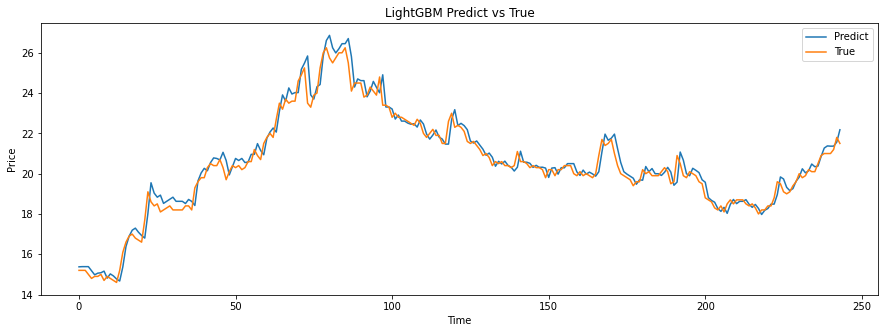

In [251]:
#Plot training and validation loss values
plt.figure(figsize=(15,5))
plt.plot( lgbm_price)
plt.plot( true_price)
plt.title('Compare result on test set')
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend(['Predict','True'], loc='upper right')
plt.show()

In [252]:

mse  = mean_squared_error(true_price,lgbm_price)
mae  = mean_absolute_error(true_price,lgbm_price)

print(f"mean_squared_error : {mse}")
print(f"mean_absolute_error : {mae}")

mean_squared_error : 0.207439352861788
mean_absolute_error : 0.3349811186159965


In [253]:
move_avg = lst_x_close[2].mean(axis=1).reshape(-1, 1)
mse  = mean_squared_error(true_price,move_avg)
mae  = mean_absolute_error(true_price,move_avg)
print(f"mean_squared_error : {mse}")
print(f"mean_absolute_error : {mae}")


mean_squared_error : 1.3282297643442618
mean_absolute_error : 0.9416803278688523


In [269]:
pd.set_option('display.max_rows', 500)

pd.DataFrame({"price_t20":lst_x_close[2][:,-1].ravel()
              ,"true_price_t21":true_price.ravel()
              ,"lgbm_price":lgbm_price.ravel()
              ,"move_avg":move_avg.ravel()})

,price_t20,true_price_t21,lgbm_price,move_avg
0,15.20,15.20,15.375395,14.5050
1,15.20,15.20,15.384452,14.5450
2,15.20,15.20,15.384452,14.5900
3,15.20,15.00,15.384525,14.6400
4,15.00,14.80,15.182097,14.6850
5,14.80,14.90,14.979598,14.7300
6,14.90,14.90,15.060395,14.7850
7,14.90,15.00,15.080812,14.8150
8,15.00,14.70,15.161472,14.8650
9,14.70,14.90,14.812698,14.8800


# Basic LSTM

## Create Model

In [21]:
seq_model = tf.keras.models.Sequential()

seq_model.add( tf.keras.layers.LSTM(units=150, input_shape=(None, 1) , return_sequences=False) ) # RNN Layer 1st
seq_model.add( tf.keras.layers.Dropout(0.3) ) #Dropout


#Use the defult 'linear activation'
seq_model.add( tf.keras.layers.Dense(1))

seq_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150)               91200     
                                                                 
 dropout (Dropout)           (None, 150)               0         
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [22]:
os.system(f"rm *.hdf5")

optmiz = tf.keras.optimizers.Nadam(learning_rate=0.0001)
seq_model.compile(loss='mse', optimizer=optmiz, metrics=['mean_absolute_error','mean_squared_error'])

checkpoint = "seq_lstm_bestmodel_epoch{epoch:03d}.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)

In [23]:
hist = seq_model.fit(x_train_norm, y_train_norm,
                  validation_data=(x_val_norm, y_val_norm),
                  batch_size=64, epochs=30,
                  callbacks=[model_checkpoint_callback])

Epoch 1/30
31/31 [==============================] - 7s 23ms/step - loss: 0.1653 - mean_absolute_error: 0.3782 - mean_squared_error: 0.1653 - val_loss: 0.0671 - val_mean_absolute_error: 0.2415 - val_mean_squared_error: 0.0671
Epoch 2/30
31/31 [==============================] - 0s 7ms/step - loss: 0.0254 - mean_absolute_error: 0.1242 - mean_squared_error: 0.0254 - val_loss: 0.0078 - val_mean_absolute_error: 0.0627 - val_mean_squared_error: 0.0078
Epoch 3/30
31/31 [==============================] - 0s 8ms/step - loss: 0.0095 - mean_absolute_error: 0.0749 - mean_squared_error: 0.0095 - val_loss: 0.0074 - val_mean_absolute_error: 0.0606 - val_mean_squared_error: 0.0074
Epoch 4/30
31/31 [==============================] - 0s 8ms/step - loss: 0.0093 - mean_absolute_error: 0.0749 - mean_squared_error: 0.0093 - val_loss: 0.0071 - val_mean_absolute_error: 0.0593 - val_mean_squared_error: 0.0071
Epoch 5/30
31/31 [==============================] - 0s 8ms/step - loss: 0.0091 - mean_absolute_error: 0

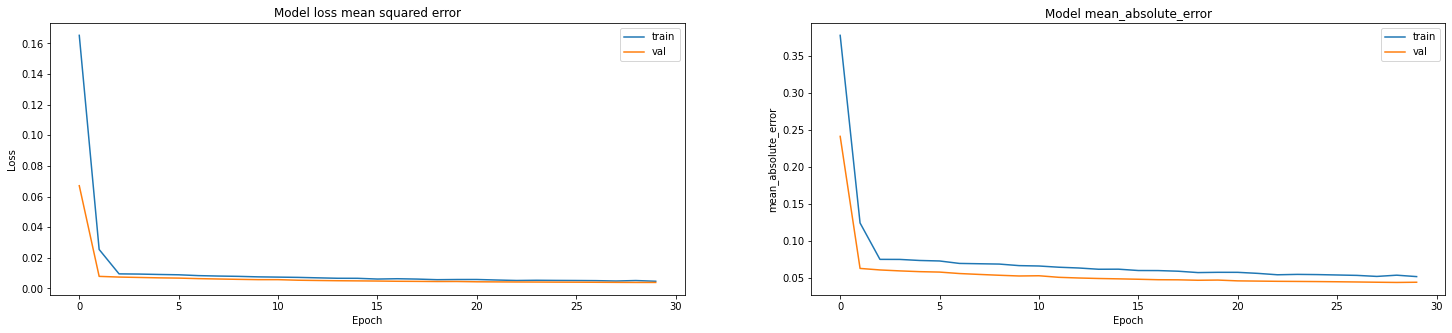

In [24]:
#Plot training and validation loss values
plt.figure(figsize=(25,5))

plt.subplot(121)
plt.plot( hist.history['loss'])
plt.plot( hist.history['val_loss'])
plt.title('Model loss mean squared error')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper right')

plt.subplot(122)
plt.plot( hist.history['mean_absolute_error'])
plt.plot( hist.history['val_mean_absolute_error'])
plt.title('Model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper right')


plt.show()

## Evaluate

In [25]:
# Load the model from the best epoch (minimum val_loss)
bestmodel_file = max([ f for f in os.listdir(".") if f.startswith('seq_lstm_bestmodel_') and f.endswith(".hdf5")])
print( f"The best model : {bestmodel_file}")

The best model : seq_lstm_bestmodel_epoch029.hdf5


In [26]:
seq_best = tf.keras.models.load_model(bestmodel_file, compile=True)

In [27]:
#Evaluate the model from last epoch
score = seq_model.evaluate(x_test_norm, y_test_norm, verbose=0)
if hasattr(score,'__len__'):
  print(f"Test results (model from the last epoch) :{[(seq_model.metrics_names[i],score[i]) for i in range(len(score))]}")
else :
   print(f"Test results (model from the last epoch) :{[(seq_model.metrics_names[0],score)]}")

Test results (model from the last epoch) :[('loss', 0.004692793358117342), ('mean_absolute_error', 0.0543329194188118), ('mean_squared_error', 0.004692793358117342)]


In [28]:
#Evaluate the model from best epoch
score = seq_best.evaluate(x_test_norm, y_test_norm, verbose=0)
if hasattr(score,'__len__'):
  print(f"Test results (model from the best epoch) :{[(seq_best.metrics_names[i],score[i]) for i in range(len(score))]}")
else :
   print(f"Test results (model from the best epoch) :{[(seq_best.metrics_names[0],score)]}")

Test results (model from the best epoch) :[('loss', 0.004808593075722456), ('mean_absolute_error', 0.054131798446178436), ('mean_squared_error', 0.004808593075722456)]


## Inference

In [29]:
true_price = lst_y_close[2]

y_last_norm = seq_model.predict(x_test_norm).reshape(-1,1)
y_last_preds = norm_tool.inverse_transform(y_last_norm)
y_last_price = (lst_x_close[2][:,-1].reshape(-1,1)*(1+y_last_preds))

y_best_norm = seq_best.predict(x_test_norm).reshape(-1,1)
y_best_preds = norm_tool.inverse_transform(y_best_norm)
y_best_price = (lst_x_close[2][:,-1].reshape(-1,1)*(1+y_best_preds))

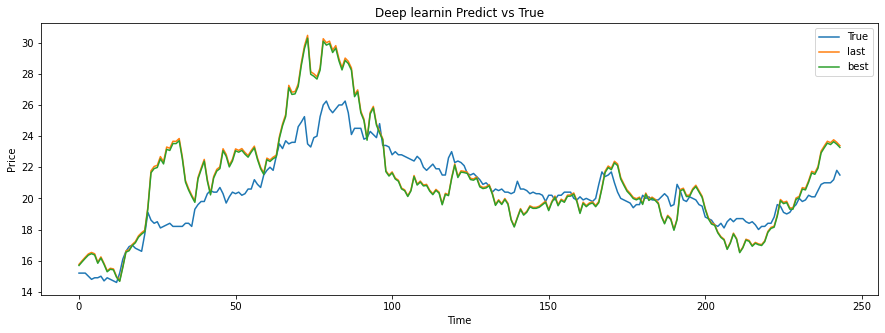

In [30]:
#Plot training and validation loss values
plt.figure(figsize=(15,5))
plt.plot( true_price)
plt.plot( y_last_price)
plt.plot( y_best_price)
plt.title('Deep learnin Predict vs True')
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend(['True','last','best'], loc='upper right')
plt.show()

In [33]:
move_avg = lst_x_close[2].mean(axis=1).reshape(-1, 1)
mse  = mean_squared_error(true_price,y_best_price)
mae  = mean_absolute_error(true_price,y_best_price)
print(f"mean_squared_error : {mse}")
print(f"mean_absolute_error : {mae}")


mean_squared_error : 3.5646784026283775
mean_absolute_error : 1.417211173157223
